In [112]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px 

In [113]:
from sklearn.impute import SimpleImputer 
from sklearn.metrics import r2_score,mean_squared_error,silhouette_score,confusion_matrix,accuracy_score 
from sklearn.preprocessing import LabelEncoder,StandardScaler,OrdinalEncoder,OneHotEncoder,MinMaxScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression,LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestRegressor

In [114]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [115]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)
mis_val

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [116]:
data.duplicated().sum()

data.drop_duplicates(subset=None,inplace=True,keep='last',ignore_index=False)

data.duplicated().sum()

0

In [117]:
le = LabelEncoder()

orig_sex = data.sex 
orig_sex_dic = np.unique(orig_sex)

data.sex = le.fit_transform(data.sex)

data.smoker = le.fit_transform(data.smoker)

data.region = le.fit_transform(data.region)

le_sex = data.sex 
le_sex_dic = np.unique(le_sex)

sex_dic = dict(zip(orig_sex_dic,le_sex_dic))

sex_dic

{'female': 0, 'male': 1}

<AxesSubplot:title={'center':'Correlation Matrix'}>

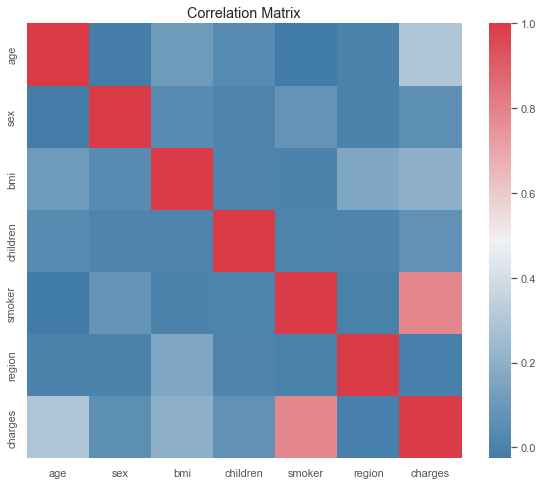

In [118]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr,dtype=np.bool_),cmap=sns.diverging_palette(240,10, as_cmap=True), square=True,ax=ax)

In [119]:
x = data.drop(columns=['charges'])
y = data.charges

In [120]:
scaler = StandardScaler() 
x = pd.DataFrame(scaler.fit_transform(x))
x

,0,1,2,3,4,5
0,-1.440418,-1.009771,-0.453160,-0.909234,1.969660,1.343163
1,-1.511647,0.990324,0.509422,-0.079442,-0.507702,0.438017
2,-0.799350,0.990324,0.383155,1.580143,-0.507702,0.438017
3,-0.443201,0.990324,-1.305052,-0.909234,-0.507702,-0.467128
4,-0.514431,0.990324,-0.292456,-0.909234,-0.507702,-0.467128
...,...,...,...,...,...,...
1332,0.767704,0.990324,0.050269,1.580143,-0.507702,-0.467128
1333,-1.511647,-1.009771,0.206053,-0.909234,-0.507702,-1.372274
1334,-1.511647,-1.009771,1.014490,-0.909234,-0.507702,0.438017
1335,-1.297958,-1.009771,-0.797524,-0.909234,-0.507702,1.343163


In [121]:
y = scaler.fit_transform(np.array(y).reshape(-1,1))
y

array([[ 0.2978567 ],
       [-0.9543806 ],
       [-0.72937251],
       ...,
       [-0.96228744],
       [-0.9310536 ],
       [ 1.31029752]])

In [122]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.3)

In [123]:
linreg = LinearRegression()

linreg.fit(x_train,y_train)

y_pred = linreg.predict(x_test)

r2_scr = r2_score(y_test,y_pred).round(3)
mse_scr = mean_squared_error(y_test,y_pred).round(3)

modperf = pd.DataFrame( 
    [ 
        'LinearRegression', r2_scr,mse_scr
    ]
).transpose()

modperf.columns = ['Method', 'R2 Test Score', 'Mse Test Score']

modperf

,Method,R2 Test Score,Mse Test Score
0,LinearRegression,0.765,0.271


In [124]:
ranfor = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42,criterion='squared_error')

ranfor.fit(x_train,y_train)

y_pred = ranfor.predict(x_test)

scr_mse = mean_squared_error(y_test,y_pred).round(3)

scr_mse

C:\Users\amunv\AppData\Local\Temp\ipykernel_20884\3821393543.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.181